# COGS 118A - Final Project

# Predicting California Housing Prices

## Group Members

- Sreetama Chowdhury
- Lucy Lenneman
- Prabhjyot Sodhi
- Sukhman Virk

# Abstract 
The goal of this project is to use a set of factors about the houses in a neighborhood to predict median house value within that neighborhood. We intend for this to be a regression task, with the data we use containing such variables as latitude/longitude, the population of a block of houses, the number of households within a block, and more. We plan to conduct model selection across several different model types (linear regression, kNN, random forest, decision trees) so as to optimize for minimum error, after which we will test the final and best model and see how accurately it can predict pricing. Accuracy will be measured via metrics like mean absolute error.

# Background

The prediction of house prices in a certain area is a well researched topic in the field of Machine Learning. There have been several instances of research conducted to develop accurate models using various datasets. The dataset we used is the California House Prices dataset available on Kaggle, which provides information taken from the 1990 CA Census about housing features and corresponding prices in different neighborhoods of California. There have been studies that have utilized similar datasets to try to model the relationship between house attributes and their prices, employing various machine learning algorithms such as regression, random forests, and SVMs.<a name="huang"></a>[<sup>[1]</sup>](#huangnote),<a name="manasa"></a>[<sup>[2]</sup>](#manasanote)

These studies have tried to create accurate models that can estimate house prices based on a variety of features. Researchers have aimed to provide insights using these models for not only homebuyers, but also sellers and real estate professionals, helping them in making informed decisions regarding housing investments.

The California housing dataset that our project is using is a modified version of the California Housing dataset, initially featured in a paper by Pace, R. Kelley, and Ronald Barry about simultaneous autoregressions.<a name="pace"></a>[<sup>[3]</sup>](#pacenote)

# Problem Statement

Searching for housing is a tricky thing throughout the state of California, as we as UCSD students well know; there are a preponderance of factors (the most important of which is *price*) that determine whether a home in a given location is a good fit for a resident. House price is a key factor in many decisions on both ends of the spectrum: the areas a potential buyer looks at when house hunting depends largely on what house price tends to be in those areas, or current homeowners planning to move out may hesitate to sell their home until they can have a good estimate of how much they'll get for it. 

Our project aims to use various given factors about the houses in a given California neighborhood to predict (via several ML models such as linear regression, k nearest neighbors, decision trees, and random forests) the neighborhood's median house value, providing people with a numerically analyzable measure of central tendency that could sway them in their real estate decisions. In other words, our project will be able to answer the question of: given such variables as median house age, number of rooms, and median income within a block of houses, can we predict what the median house price of a house in that block/neighborhood would be? 

# Setup

In [100]:
# import any needed libraries here
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Data

The dataset that we are using is a collection of 1990 CA Census data from Kaggle, <a name="nugent"></a>[<sup>[4]</sup>](#nugentnote) which is about California housing prices. These features are measured for a block of houses and include:

* Longitude of houses (with two significant figures)
* Latitude of houses (with two significant figures) 
* Housing median age (with one significant figure) 
* Total rooms of houses (with one significant figure) 
* Total bedrooms of houses (with one significant figure)
* Population around houses (with one significant figure)
* Number of households (units of people living together)(with one significant figure)
* Median income of house owners (with four significant figures)
* Median house value (with one significant figure)
* Ocean proximity from houses (Near Bay / <1H ocean / Inland / Near Ocean / Island)

We have ten features and around 20000 observations to work with for our model. Some of the important variables we hypothesize will make a significant impact on predicting housing price are median income and population. 

To clean the data, we drop observations with missing values and one hot encode the categorical variable of proximity to the ocean. For now, we will keep all features in our models and do feature selection later if needed. 

In [143]:
df = pd.read_csv('housing.csv')
df = df.rename(columns={'longitude':'long', 'latitude': 'lat', 'housing_median_age': 'median_age', 
                        'median_house_value': 'median_price'})
df = df.dropna(axis='index') # remove observations with missing values

In [144]:
# one hot encode the variable ocean_proximity
encoder = OneHotEncoder(handle_unknown='error')
transformed = encoder.fit_transform(df[['ocean_proximity']])
# encoder.categories_ returns 2D array with an array of the category names as index 0
df[['<1H_ocean', 'inland', 'island', 'near_bay', 'near_ocean']] = transformed.toarray() 
df = df.drop(['ocean_proximity'], axis='columns')
df.head()

,long,lat,median_age,total_rooms,total_bedrooms,population,households,median_income,median_price,<1H_ocean,inland,island,near_bay,near_ocean
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,0.0,1.0,0.0


# Exploratory Data Analysis

Our first step is to explore what trends already exist in the data and see what algorithms might be appropriate.

In [145]:
df.describe()

,long,lat,median_age,total_rooms,total_bedrooms,population,households,median_income,median_price,<1H_ocean,inland,island,near_bay,near_ocean
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155,0.442128,0.317917,0.000245,0.111095,0.128615
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099,0.496652,0.465678,0.015641,0.314257,0.334782
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Some interesting things we can see about our data here are that the mean median price of a house in California 1990 is $206k. Moreover, we notice that there are some different orders of magnitude in our data, for example comparing the standard deviation of the variable longitude to the standard deviation of median house price. Looking at the mean for variables that were one hot encoded from the original variable proximity to the ocean, the mean for the variable less than one hour from the ocean is much higher than the mean for islands, meaning that there are more houses close to the ocean than houses on islands. After noticing this fact, we want to check the distribution for both categorical and continuous variables. 

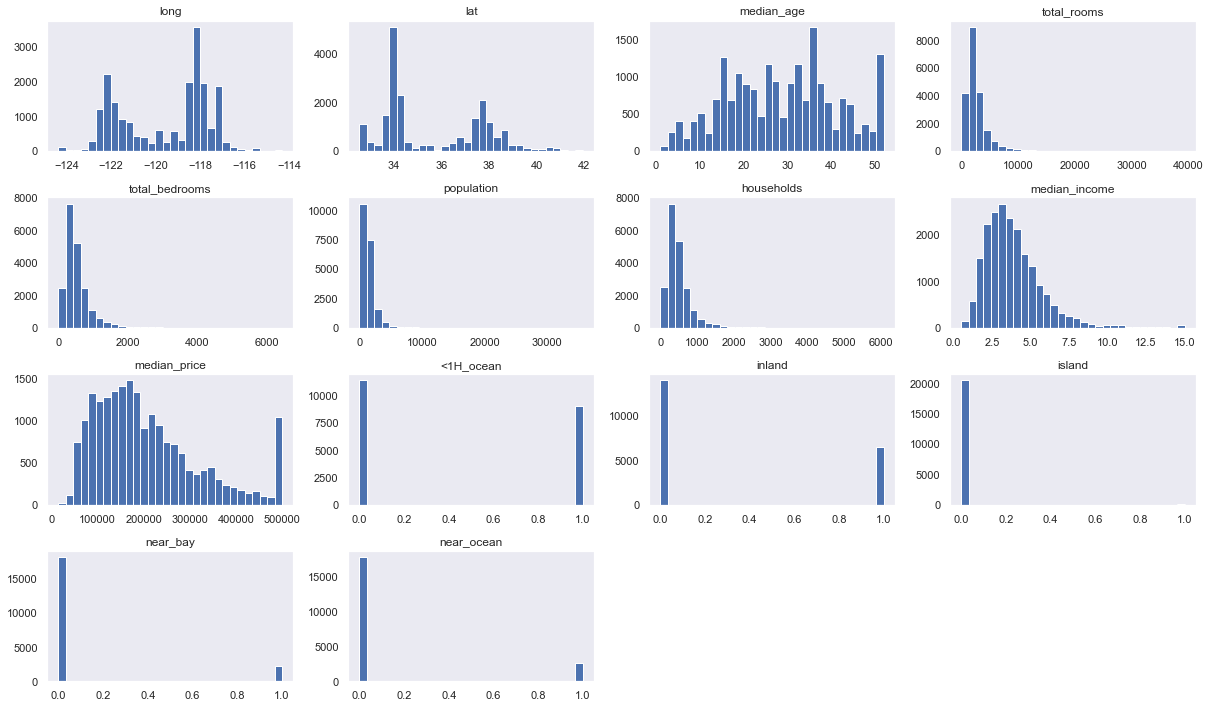

In [147]:
hist = df.hist(bins=30, figsize=(17, 10), grid=False)
plt.tight_layout()
plt.show()

As expected, some variables have pretty unnormal distributions, such as longitude and latitude, as this is geographical data. Other variables have normal distributions, which is good for our analysis, such as total rooms per neighborhood and median outcome. For variables like median house price and median income, we observe that there are a few extreme outliers on the higher end of the price range. For the variables describing how close the house is to the ocean, we can see the counts of how many houses we have in each category. There are the most houses that are less than an hour from the ocean, followed by in the inland category, and the least in the island category. Therefore, we must consider that some categories are not as equally represented by our data. 

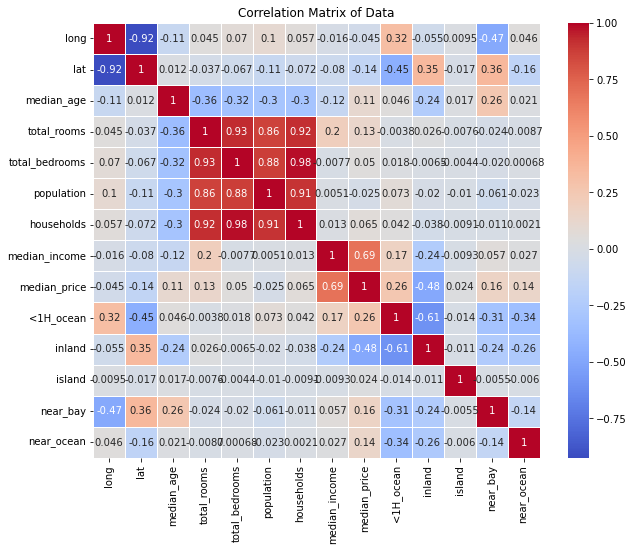

In [105]:
correlation = df.corr() 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.8) 
plt.title('Correlation Matrix of Data') 
plt.show() 

We have used a correlation matrix of data since it shows and tells us the strength of variables between them. From the graph, we can say that household data are very strongly correlated. 

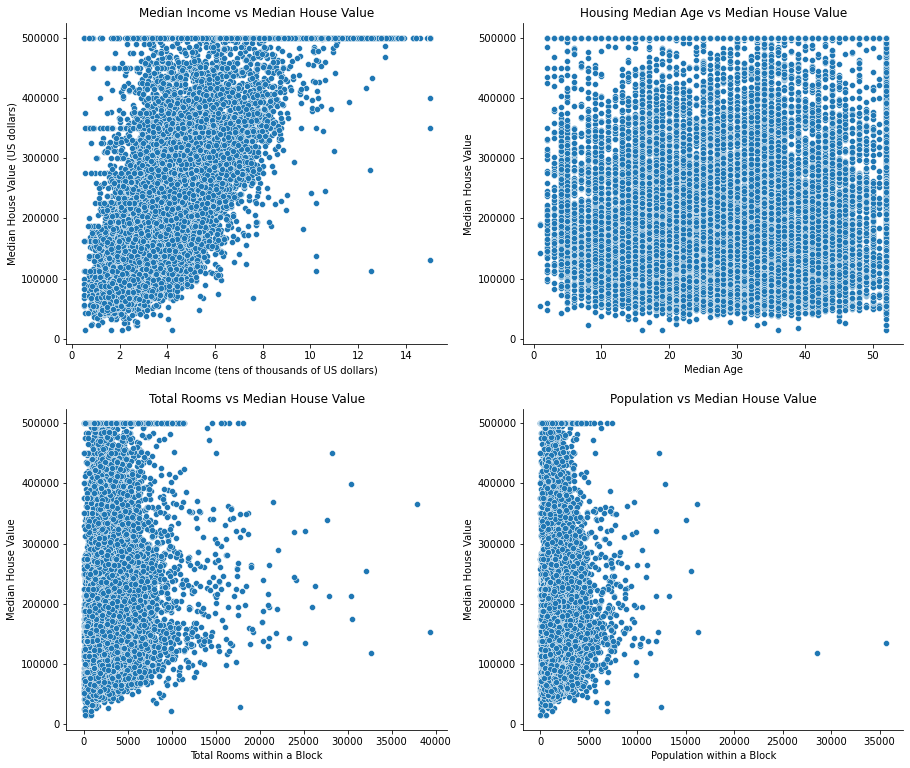

In [106]:
plt.figure(figsize=(15, 13))

plt.subplot(2, 2, 1)
sns.scatterplot(x='median_income', y='median_price', data=df)
plt.title('Median Income vs Median House Value') 
plt.xlabel('Median Income (tens of thousands of US dollars)')
plt.ylabel('Median House Value (US dollars)')

plt.subplot(2, 2, 2)
sns.scatterplot(x='median_age', y='median_price', data=df) 
plt.title('Housing Median Age vs Median House Value') 
plt.xlabel('Median Age')
plt.ylabel('Median House Value')

plt.subplot(2, 2, 3)
sns.scatterplot(x='total_rooms', y='median_price', data=df) 
plt.title('Total Rooms vs Median House Value') 
plt.xlabel('Total Rooms within a Block')
plt.ylabel('Median House Value')

plt.subplot(2, 2, 4)
sns.scatterplot(x='population', y='median_price', data=df)
plt.title('Population vs Median House Value') 
plt.xlabel('Population within a Block')
plt.ylabel('Median House Value')

sns.despine()
plt.show()

We have used scatterplots so that we can see a visual representation of variables in the housing data. 

# Proposed Solution

After considering our EDA, one solution to our problem is to implement a multivariate regression model because we are utilizing multiple variables, such as proximity to the ocean, total rooms within a block, and number of households within a block, to predict the numerical housing prices for a given neighborhood.  Using the form $y_i = \mathbf{w}x_i + b$, we will find the optimal weight values analytically because linear regression provides a closed form solution rather than forcing us to go through gradient descent. 

We are also planning on trying a k-nearest neighbors model when doing model selection to determine the best model to approach our problem. This will cluster the neighborhoods in our training data into groups based on their similarities to each other. During testing, the kNN model will determine which cluster the test data is most similar to and predict the housing prices based on that. Because we only have ten variables, the dimension of the features is small enough that we won’t have problems with having a too large dimension where all the neighbors are far from each other.

We will select our algorithm through nested cross-validation, where the inner loop selects the best hyperparameters for each algorithm, and the outer loop determines which algorithm performed better on the test data. Once we have selected an algorithm, we will use cross validation in combination with random search to select hyperparameters to best optimize our model. We will use the Python library sklearn.


# Evaluation Metrics

For our multivariate regression model, we are planning on mean absolute error (MAE), which is represented by the following formula:  

\begin{align*}
	\text{MAE } &= |y_i - (\mathbf{w}x_i + b)| \\
\end{align*}

House prices have many outliers, for example houses that are priced extremely high, so we don’t want to rely on mean squared error. We will instead use mean absolute error, which is not as affected by outliers. By using MAE, we can make better predictions about housing prices. 


# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Maybe you include a learning curve to show whether you have enough data to do train/validate/test split or have to go to k-folds or LOOCV or ???

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?



The first step is to the split the data into useful training and test sets. We will do this using our df dataset, which is already cleaned from missing data and have the categorical features  one-hot encoded. We split the df into X and y values where X is the features that are used for prediction and y is the feature the model needs to predict, in this case the median price of houses. We also do some data preprocessing before we test any models by standardizing the data using StandardScalar to prevent any unnecessary skew or biases.\
The aim of this preprocessing was to standardize all values to a range where we can run different regressions on it successfully.

In [111]:
# given two arrays of the same size, truth and predicted
# prints metrics r2, residual mean squared error, and mean squared error
def print_metrics(truth, predicted):
    mse = mean_squared_error(y_test, predicted)
    return r2_score(truth, predicted), np.sqrt(mse), mse

In [113]:
# set predictors and response variable
X = df.drop('median_price',axis=1) 
y = df['median_price']

# take 33% of data to be in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Standardizing the values
standardizer = StandardScaler() 
X_train = standardizer.fit_transform(X_train)
X_test = standardizer.fit_transform(X_test)

We setup an array to store the error metrics of the different models we run to find the best performing model with this particular dataset. 

In [ ]:
# [LinReg, ElasticNet, randomForest, knn, decision trees]
# setup arrays to store metrics to compare algorithms
MODEL_NUM = 5
rmse, mse, r2 = np.zeros(MODEL_NUM), np.zeros(MODEL_NUM), np.zeros(MODEL_NUM)

# Linear Regression
We use a basic linear regression model with this data set to see how well it performs with certain error metrics. We didn't have to do any hyper parameter tuning here. 

In [114]:
# linear regression model
linReg = LinearRegression()
linReg.fit(X_train,y_train)
y_pred = linReg.predict(X_test)
mse[3] = mean_squared_error(y_test,y_pred)
r2[3] = r2_score(y_test,y_pred)
rmse[3] = np.sqrt(mean_squared_error(y_test, y_pred))
print_metrics(y_test, y_pred)

(0.6567605945920528, 67462.04821148927, 4551127948.889301)

# ElasticNet Regression
We use an ElasticNet regression model here and measured how well it performed on the dataset with certain error metrics. We conducted hyperparameter tuning using 5-fold Cross Validation. It tuned the hyperparamter values of alpha and l1_ratio for this  model. 
<br />
The grid search process determined that the best hyperparameters were: alpha=158.41209935798847 and l1_ratio =0.5. We see this model alraedy performing significantly better than the linear regression model.

In [115]:
# parameters to tune: l1_ratio (how much weight to give to L1 vs. L2 penalty) & 
# alpha (how much weight given to regularization, where 0 means no regularization)
elasticNet = ElasticNetCV(cv=5, random_state=42)
elasticNet.fit(X_train, y_train)

y_predEN = elasticNet.predict(X_test)
print("Alpha (amt of penalization): " + str(elasticNet.alpha_))
print("l1_ratio (ratio between L1 and L2 penalty): " + str(elasticNet.l1_ratio_))
mse[4] = mean_squared_error(y_test,y_predEN)
r2[4] = r2_score(y_test,y_predEN)
rmse[4] = np.sqrt(mean_squared_error(y_test, y_predEN))
print_metrics(y_test, y_predEN)

Alpha (amt of penalization): 158.41209935798847
l1_ratio (ratio between L1 and L2 penalty): 0.5


(0.02141120790915796, 113909.79515553617, 12975441432.37621)

# Feature-Selection
We conduct feature selection in this section. We try to identify the most relevant features from the dataset and discard irrelevant ones. With this dataset, conducting feature selection can provide several benefits and help improve the performance of predictive models since it helps reduce dimensionality of the data. It also helps reduce overfitting.<br />
We use PCA here for feature selection. The code calculates the explained variance ratio and singular values for each feature in the data. These values help us indicate the importance of each principal component and we can determine which principal components capture the most amount of information.
<br />
We also use a pairplot visualisation to see the relation between different features to see how correlated they are. 

In [116]:
pca = PCA(n_components = 13)
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[3.01046774e-01 1.97455587e-01 1.27144528e-01 9.65775016e-02
 8.28801458e-02 7.66492421e-02 5.47061486e-02 4.37250928e-02
 1.18628699e-02 4.73721384e-03 2.03810166e-03 1.17679442e-03
 3.68713599e-33]
[2.31467696e+02 1.87459785e+02 1.50425768e+02 1.31102624e+02
 1.21450317e+02 1.16795829e+02 9.86714410e+01 8.82142549e+01
 4.59481769e+01 2.90358734e+01 1.90452344e+01 1.44718383e+01
 2.56163930e-14]


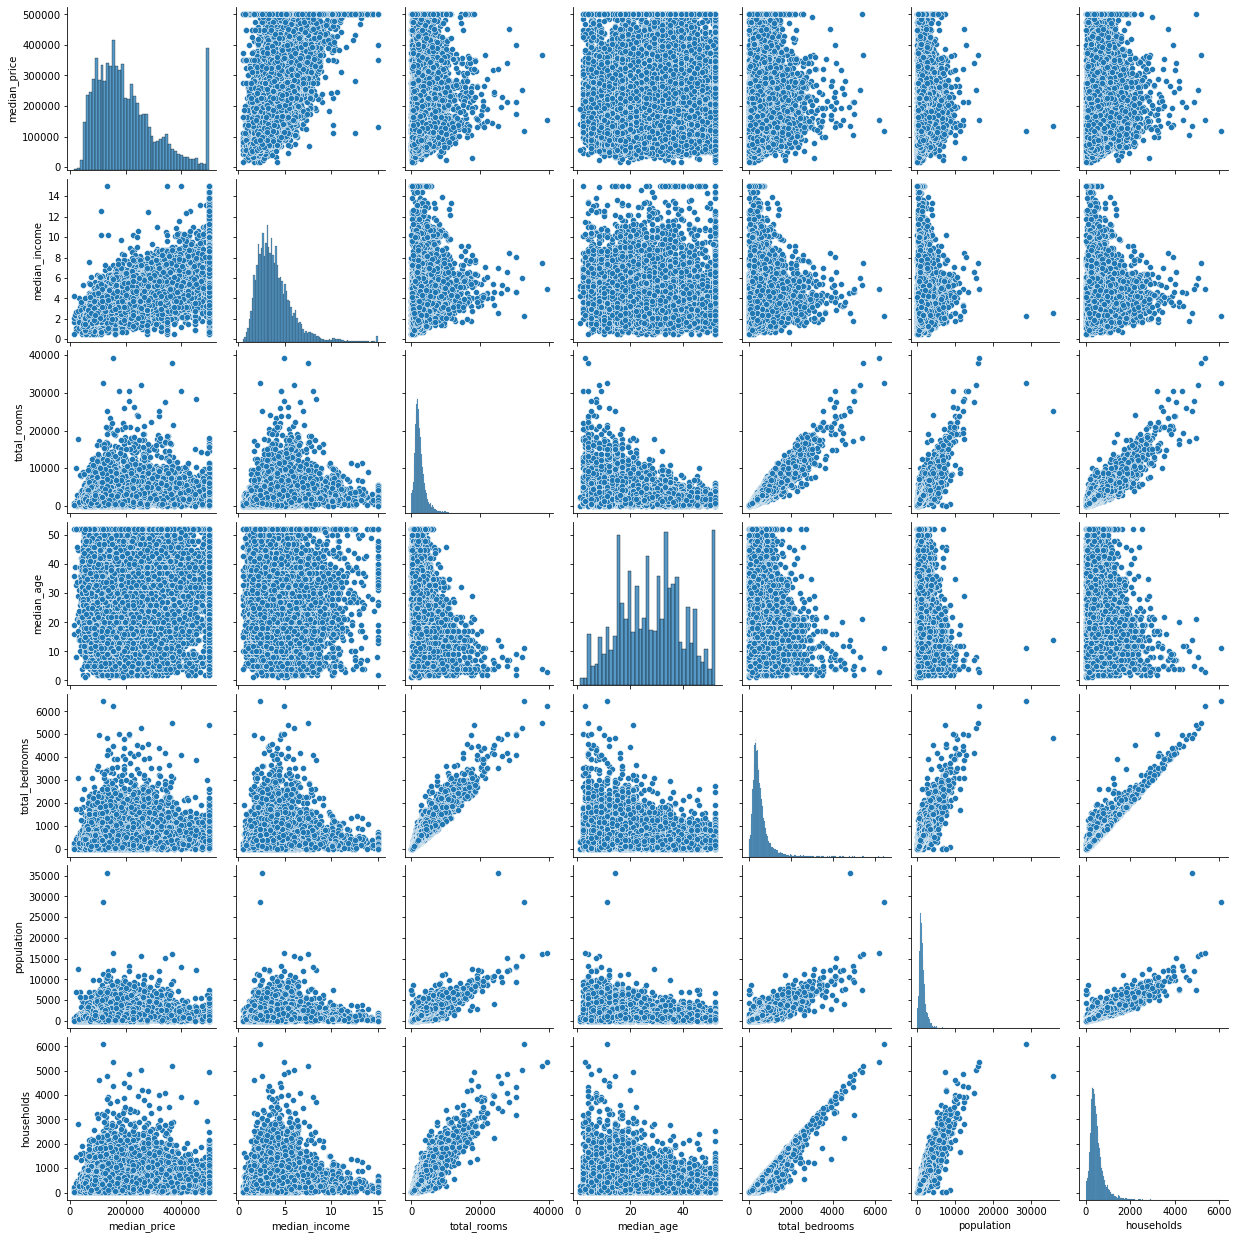

In [117]:
att=["median_price","median_income","total_rooms","median_age","total_bedrooms","population","households"]
scatter = sns.pairplot(df[att])

# Cross-Validation

For our model selection, we decided to use cross-validation. Some limitations to our work is that especially for models like the random forest that have much slower training times, we weren't able to extensively test many combinations of hyperparameters. For the random forest, KNN, and decision tree models, we selected a few hyperparameters to tune after reading some literature about some typically tuned hyperparameters. We selected these hyperparameters based on the negative mean absolute error metric, which isn't as affected by large error values. To get an overall estimate of how these models might generalize after tuning hyperparameters, we printed a few metrics.

In [85]:
# Random forest model: cross validation
randomForest = RandomForestRegressor(random_state = 42)
randForestcv = GridSearchCV(randomForest, 
                           param_grid={'n_estimators': [100, 300, 500], 
                                   'max_features': ['sqrt', 'log2' , None],
                                    'max_depth': [20, 40, None]},
                           scoring='neg_mean_absolute_error',
                           cv=5)
randForestcv = randForestcv.fit(X_train, y_train)
y_predRF = randForestcv.predict(X_test)
print(randForestcv.best_params_)
print_metrics(y_test, y_predRF)

{'max_depth': 40, 'max_features': None, 'n_estimators': 500}


(0.7644169336093909, 67462.04821148927, 4551127948.889302)

In [86]:
# store best parameters
# {'max_depth': 40, 'max_features': None, 'n_estimators': 500}
randForestbest = randForestcv.best_params_

In [139]:
# knn model
knn = KNeighborsRegressor()
knnparams = {'leaf_size': range(1, 50, 5),
            'n_neighbors': range(1, 30, 5)}
knncv = GridSearchCV(knn,
                    param_grid=knnparams,
                     scoring='neg_mean_absolute_error',
                    cv=5)
knncv = knncv.fit(X_train, y_train)
y_predKnn = knncv.predict(X_test)
print(knncv.best_params_) # {'leaf_size': 1, 'n_neighbors': 11}
print_metrics(y_test, y_predKnn)

{'leaf_size': 1, 'n_neighbors': 11}


(0.7266978852023556, 60198.05345589862, 3623805639.879227)

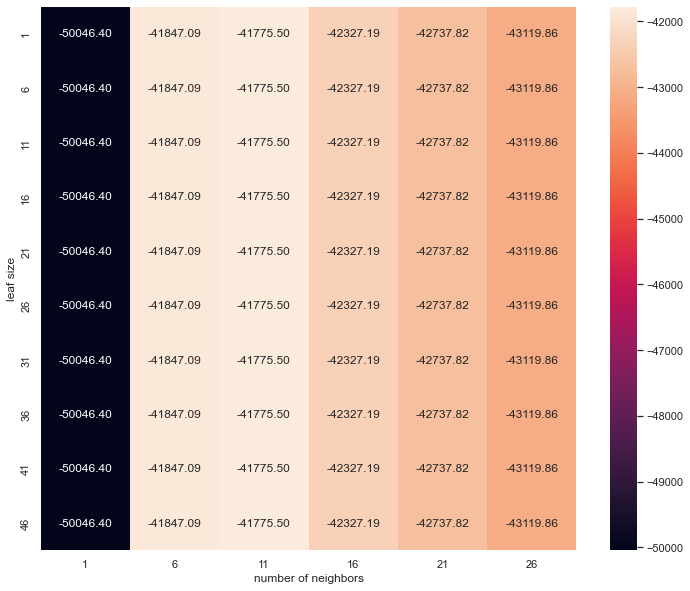

In [120]:
sns.set(rc={'figure.figsize':(12, 10)})
cvresults = knncv.cv_results_
df = pd.DataFrame(cvresults['params'])
df['accuracy'] = cvresults['mean_test_score']
plot = sns.heatmap(df.pivot('leaf_size', 'n_neighbors'), 
                   annot=True, fmt='3.2f', xticklabels=range(1, 30, 5))
plot = plot.set(xlabel="number of neighbors", ylabel="leaf size")

In [121]:
# decision tree
decisionTree = DecisionTreeRegressor()
dtparams = {'max_depth': [10, 20, 30, 40, 100, None],
            'max_features': ['sqrt', None],
            'min_samples_split': [10, 50, 100]}
decisionTreecv = GridSearchCV(decisionTree, 
                             param_grid=dtparams,
                             scoring='neg_mean_absolute_error',
                             cv=5)
decisionTreecv = decisionTreecv.fit(X_train, y_train)
y_predDt = decisionTreecv.predict(X_test)
print(decisionTreecv.best_params_) #{'max_depth': None, 'max_features': None, 'min_samples_split': 50}
print_metrics(y_test, y_predDt)

{'max_depth': None, 'max_features': None, 'min_samples_split': 50}


(0.6457917893525166, 68531.50418627437, 4696567066.03334)

Because heatmaps can only display combinations of two different hyperparameters, we plot a different visualization here: validation curves, which illustrate the mean training and validation error averaged across 5 folds of cross-validation. Higher negative mean absolute error means the model performed better. In this report, we show a few examples with some hyperparameters from the KNN and decision tree models. 

In [ ]:
def validation_graph(estimator, hyperparams, param):
    train, valid = validation_curve(estimator, X_train, y_train, param_name=param, param_range=hyperparams, cv=5, 
                                    scoring='neg_mean_absolute_error')
    train_mean = np.mean(train, axis=1)
    valid_mean = np.mean(valid, axis=1)
    fig = sns.lineplot(data=pd.DataFrame(data={'train': train_mean, 'valid': valid_mean}, index=hyperparams), markers=True)
    plt.xlabel(param)
    plt.ylabel('Negative Mean Absolute Error')
    return fig

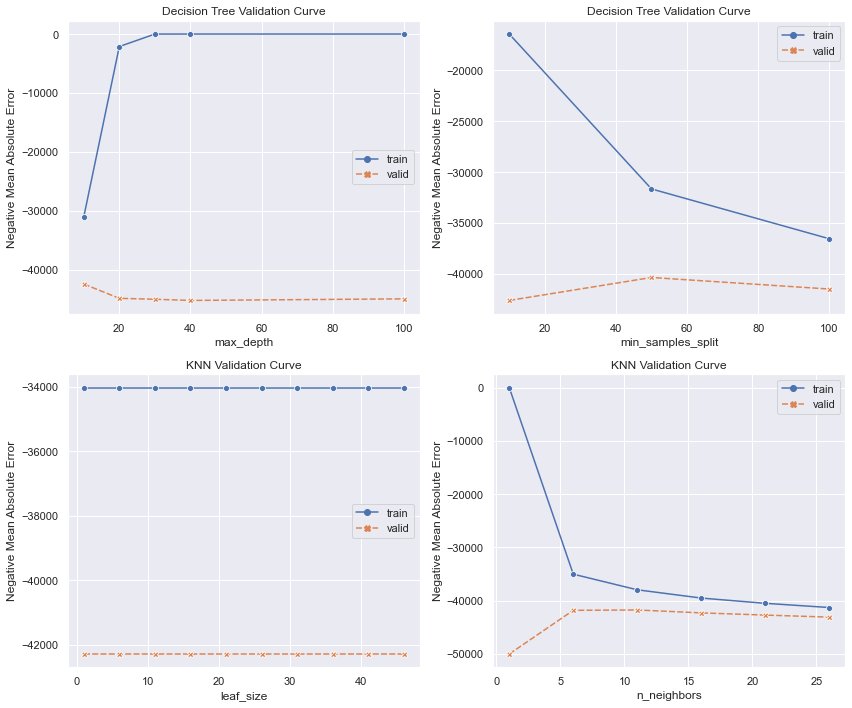

In [141]:
plt.subplot(2, 2, 1)
validation_graph(decisionTree, dtparams['max_depth'], 'max_depth')
plt.title('Decision Tree Validation Curve')

plt.subplot(2, 2, 2)
validation_graph(decisionTree, dtparams['min_samples_split'], 'min_samples_split')
plt.title('Decision Tree Validation Curve')

plt.subplot(2, 2, 3)
validation_graph(knn, knnparams['leaf_size'], 'leaf_size')
plt.title('KNN Validation Curve')

plt.subplot(2, 2, 4)
validation_graph(knn, knnparams['n_neighbors'], 'n_neighbors')
plt.title('KNN Validation Curve')

plt.tight_layout()
plt.show()

# Running the Actual Models with Best Hyperparameters

In [32]:
randomForest = RandomForestRegressor(n_estimators=500, max_depth=40, max_features=None)
randomForest.fit(X_train, y_train)
y_predRF = randomForest.predict(X_test)
mse[0] = mean_squared_error(y_test,y_predRF)
r2[0] = r2_score(y_test,y_predRF)
rmse[0] = np.sqrt(mean_squared_error(y_test, y_predRF))
print_metrics(y_test, y_predRF)

(0.7648912806499383, 55833.56004314377, 3117386427.0913405)

In [33]:
knn = KNeighborsRegressor(leaf_size=1, n_neighbors=11)
knn.fit(X_train, y_train)
y_predKnn = knn.predict(X_test)
mse[1] = mean_squared_error(y_test,y_predKnn)
r2[1] = r2_score(y_test,y_predKnn)
rmse[1] = np.sqrt(mean_squared_error(y_test, y_predKnn))
print_metrics(y_test, y_predKnn)

(0.7266978852023556, 60198.05345589862, 3623805639.879227)

In [34]:
decisionTree = DecisionTreeRegressor(max_depth=100, max_features=None, min_samples_split=50)
decisionTree.fit(X_train, y_train)
y_predDt = decisionTree.predict(X_test)
mse[2] = mean_squared_error(y_test,y_predDt)
r2[2] = r2_score(y_test,y_predDt)
rmse[2] = np.sqrt(mean_squared_error(y_test, y_predDt))
print_metrics(y_test, y_predDt)

(0.6489092993781358, 68229.25282393131, 4655230940.91194)

| Model | RMSE| MSE| R2 |
|---|---|---|---|
| Linear Regression | 67462.04821148927 | 4551127948.889301 | 0.6567605945920528 |
| ElasticNet | 113909.79515553617 | 12975441432.37621 | 0.02141120790915796 |
| Random Forest  |  55833.56004314377 |  3117386427.0913405  | 0.7648912806499383 | 
| K Nearest Neighbors  |  60198.05345589862 |  3623805639.879227 | 0.7266978852023556 | 
| Decision Tree | 68229.25282393131 | 4655230940.91194 | 0.6489092993781358 |

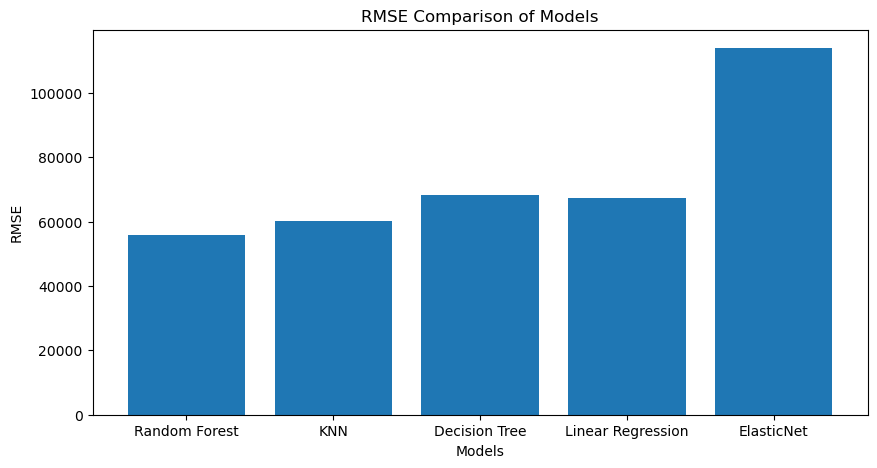

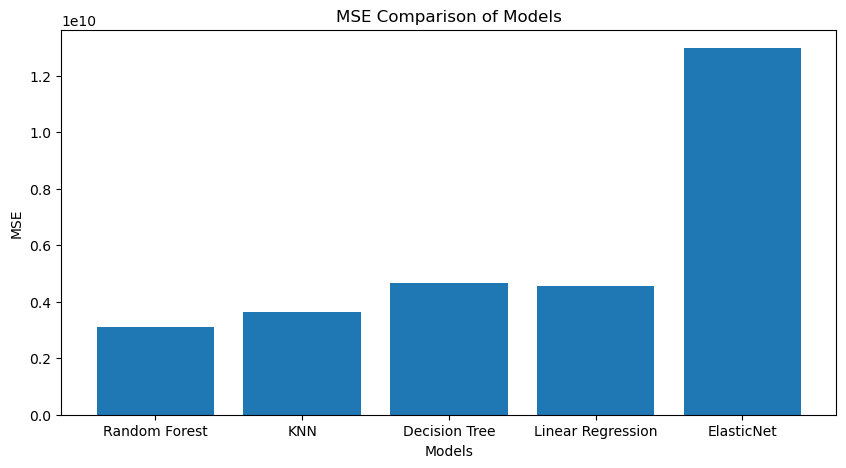

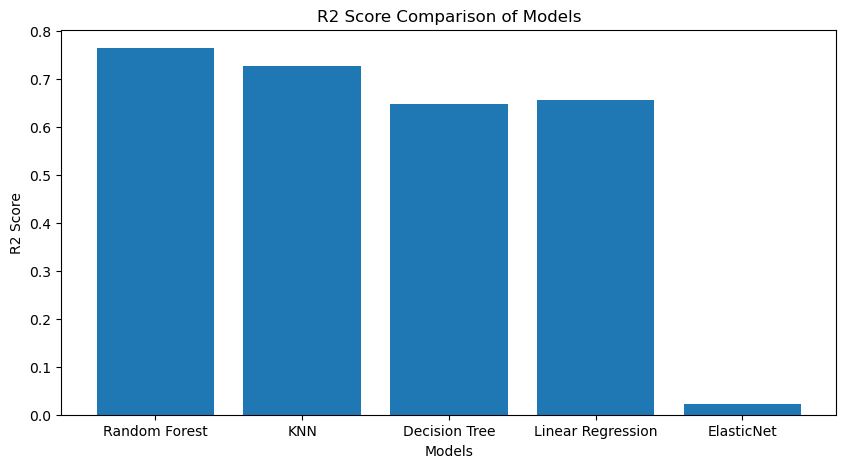

In [36]:
# prints metrics r2, residual mean squared error, and mean squared error
#r2, rmse, mse = 

models = ['Random Forest', 'KNN', 'Decision Tree', 'Linear Regression', 'ElasticNet']

plt.rcParams['figure.figsize'] = (10, 5)

plt.bar(models, rmse)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Models')
plt.show()

plt.bar(models, mse)
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('MSE Comparison of Models')
plt.show()

plt.bar(models, r2)
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('R2 Score Comparison of Models')
plt.show()

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

### Ethics & Privacy

If your project has obvious potential concerns with ethics or data privacy discuss that here.  Almost every ML project put into production can have ethical implications if you use your imagination. Use your imagination.

Even if you can't come up with an obvious ethical concern that should be addressed, you should know that a large number of ML projects that go into producation have unintended consequences and ethical problems once in production. How will your team address these issues?

Consider a tool to help you address the potential issues such as https://deon.drivendata.org

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="lorenznote"></a>1.[^](#lorenz): Lorenz, T. (9 Dec 2021) Birds Aren’t Real, or Are They? Inside a Gen Z Conspiracy Theory. *The New York Times*. https://www.nytimes.com/2021/12/09/technology/birds-arent-real-gen-z-misinformation.html<br> 
<a name="admonishnote"></a>2.[^](#admonish): Also refs should be important to the background, not some randomly chosen vaguely related stuff. Include a web link if possible in refs as above.<br>
<a name="sotanote"></a>3.[^](#sota): Perhaps the current state of the art solution such as you see on [Papers with code](https://paperswithcode.com/sota). Or maybe not SOTA, but rather a standard textbook/Kaggle solution to this kind of problem
